In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import pycountry
import matplotlib.pyplot as plt
from fredapi import Fred
from pandas_datareader import data

fred_key = '6961dec06957f1b514cbb8c91aa35a91'

In [2]:
# Gráficos a serem feitos:
    # 1: Índice Dow Jones, Fonte: Yahoo Finance (pandas datareader, api=yahoo)
    # 2: Crescimento da Moeda. Fonte: Fred St Louis (fredapi)
    # 3: Inflação e Crescimento da moeda/ Nível de Preços e Oferta de Moeda, Fonte: Fred St Louis (fredapi)
    # 4: Inflação X Moeda entre países, Fonte: World Bank (api imf)
    # 5: Oferta de Moeda e Taxa de Juros, Fonte: Fred St Louis (fredapi)
    # 6: Deficit ou Superavit governamental como % do PIB, Fonte: Fred St Louis (fredapi)

## Definindo os métodos geradores de gráficos

In [3]:
def plot_line_graph(series_list: list, y_label: str, x_label: str, source: str):
    fig, axis = plt.subplots(figsize=(20,15))
    for series in series_list:
        axis.plot(series['data'], label=series['label'], color=series['color'])
        if len(series_list) > 1:
            axis.legend()
    axis.set_ylabel(y_label, fontsize=15)
    axis.set_xlabel(x_label, fontsize=15)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.yaxis.grid(alpha = 0.2)
    axis.xaxis.grid(alpha = 0.2)
    fig.text(0.5, 0.01, source, wrap=True, horizontalalignment='left', fontsize=15)
    plt.show()

In [4]:
def plot_scatter_graph(scatter_dict, y_label: str, x_label: str, source: str):
    fig, axis = plt.subplots(figsize=(20,15))
    point_names = list(scatter_dict['series'].index)
    x_coord = scatter_dict['series'][scatter_dict['x_axis']]
    y_coord = scatter_dict['series'][scatter_dict['y_axis']]
    for i, code in enumerate(point_names):
        axis.scatter(x=x_coord[i], y=y_coord[i])
        axis.text(x_coord[i], y_coord[i], code)
        axis.set_xlim(0, 30)
    axis.set_ylabel(y_label, fontsize=15)
    axis.set_xlabel(x_label, fontsize=15)
    fig.text(0.5, 0.01, source, wrap=True, horizontalalignment='left', fontsize=15)
    plt.show()

In [23]:
def plot_fill_graph(dataframe, series,label_positive: str, label_negative: str, y_label: str, x_label: str, source: str):
    fig, axis = plt.subplots(figsize = (20,15))

    positive_coord = [i if i > 0 else 0 for i in dataframe[series]]
    negative_coord = [i if i <= 0 else 0 for i in dataframe[series]]

    x_val = dataframe.index

    axis.fill_between(x_val, positive_coord, color='skyblue', alpha=0.3)
    axis.plot(x_val, positive_coord, color='blue', label=label_positive)
    axis.fill_between(x_val, negative_coord, color='navajowhite', alpha=0.3)
    axis.plot(x_val, negative_coord, color='red', label=label_negative)

    axis.set_ylabel(y_label)
    axis.legend()

    fig.text(0.5, 0.01, source, wrap=True, horizontalalignment='left', fontsize=15)
    plt.show()

## Definindo Método que Busca dados da api do Fred

In [6]:
#Conectando na API do Fred
fred = Fred(api_key= fred_key)

# Método para consulta de dados do fred
def get_fred_data(fred_con, series, variable, has_growth=False, has_interest=False, has_index=False):
    fred_data = pd.DataFrame(fred.get_series(series)).reset_index()
    fred_data.rename(columns={'index': 'date', 0: variable}, inplace=True)
    fred_data = fred_data.set_index('date')
    if has_growth:
        fred_data['growth'] = fred_data[variable].pct_change(periods=12)
    if has_interest:
        fred_data['interest'] = fred_data[variable].apply(lambda x: x/100)
    if has_index:
        fred_data['index'] = ((fred_data[variable])/(fred_data[variable].loc['1987-01-01']))*100
    return fred_data


### Pegando as bases do Fred

In [7]:
# Dados de Crescimento da Moeda
m2_data = get_fred_data(
    fred_con=fred,
    series='M2NS',
    variable='value',
    has_growth=True,
    has_index=True
)

# Dados do Deflator do PIB dos EUA
def_data = get_fred_data(
    fred_con=fred,
    series='GDPDEF',
    variable='deflator',
    has_index=True
)

# Dados de Juros dos EUA
interest_data = get_fred_data(
    fred_con=fred,
    series='GS10',
    variable='interest',
    has_interest=True
)

# GDP data
gdp = get_fred_data(
    fred_con=fred,
    series='GDPA',
    variable= 'GDP'
)

# Deficit data
deficit = get_fred_data(
    fred_con=fred,
    series='M318501A027NBEA',
    variable='deficit'
)

#
gdp_def_df = gdp.join(deficit['deficit'])
gdp_def_df['share'] = (gdp_def_df['deficit']/gdp_def_df['GDP'])*100
gdp_def_df.dropna(inplace=True)

### Definindo os Dicionários de dados do Fred

In [8]:
# Dicionario para a série de crescimento da moeda
m2_growth_list = [
    {
        'data': m2_data['growth'],
        'label': '',
        'color': 'purple'
    }
]

# Dicionario para Nível de Precos x Oferta de Moeda
def_offer_list = [
    {
        'data': m2_data['index'],
        'label': 'M2',
        'color': 'orange'
    },
    {
        'data': def_data['index'],
        'label': 'Deflator do PIB',
        'color': 'blue'
    }
]

# Dicionario para Juros X Oferta de Moeda
offer_int_list = [
    {
        'data': interest_data['interest'],
        'label': 'Juros 10 anos',
        'color': 'blue'
    },
    {
        'data': m2_data['growth'],
        'label': 'Crescimento M2',
        'color': 'red'
    }
]

# Gráfico do Índice Dow Jones

In [9]:
index = "^DJI"
api = "yahoo"
dji_data = data.DataReader(index, api, start=1970)
# Visualizando os dados
dji_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1992-01-02,3172.629883,3139.310059,3152.100098,3172.399902,23550000,3172.399902
1992-01-03,3210.639893,3165.919922,3172.399902,3201.500000,23620000,3201.500000
1992-01-06,3213.330078,3191.860107,3201.500000,3200.100098,27280000,3200.100098
1992-01-07,3210.199951,3184.479980,3200.100098,3204.800049,25510000,3204.800049
1992-01-08,3229.199951,3185.820068,3204.800049,3203.899902,29040000,3203.899902
...,...,...,...,...,...,...
2022-08-25,33306.089844,32889.851562,33029.269531,33291.781250,308530000,33291.781250
2022-08-26,33364.699219,32278.220703,33293.429688,32283.400391,352850000,32283.400391
2022-08-29,32325.160156,31972.789062,32188.000000,32098.990234,317820000,32098.990234


### Organizando os dados para a plotagem

In [10]:
dji_series = [
    {
        'data': dji_data['Close'],
        'label': '',
        'color': 'green'
    }
]

### Plotando o Gráfico: Dow Jones Industrial Average

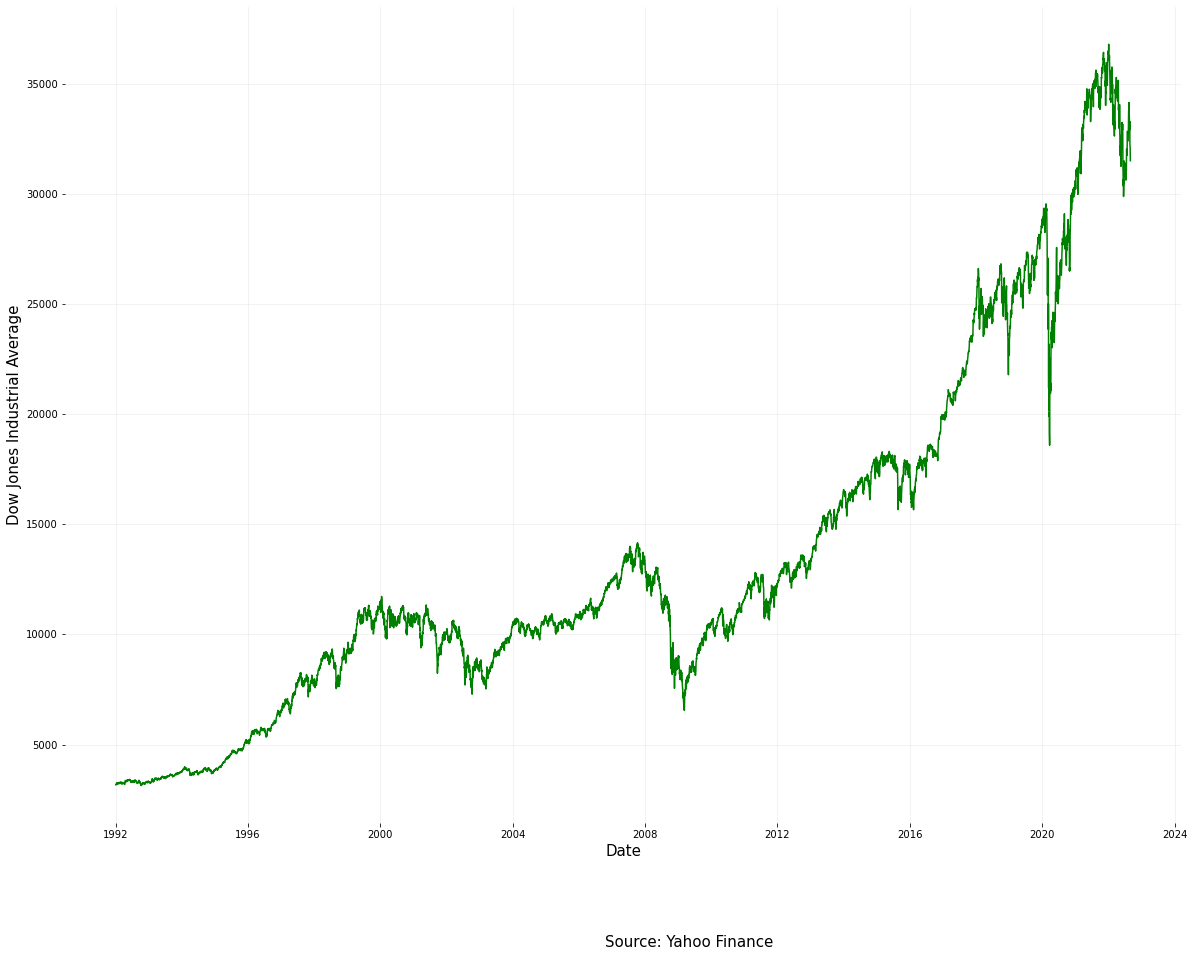

In [11]:
plot_line_graph(
    series_list=dji_series,
    y_label="Dow Jones Industrial Average",
    x_label="Date",
    source='Source: Yahoo Finance'
)

# Crescimento da Moeda e Ciclo Econômico

### Plotando o Gráfico: Taxa de Crescimento da Moeda (%a.a)

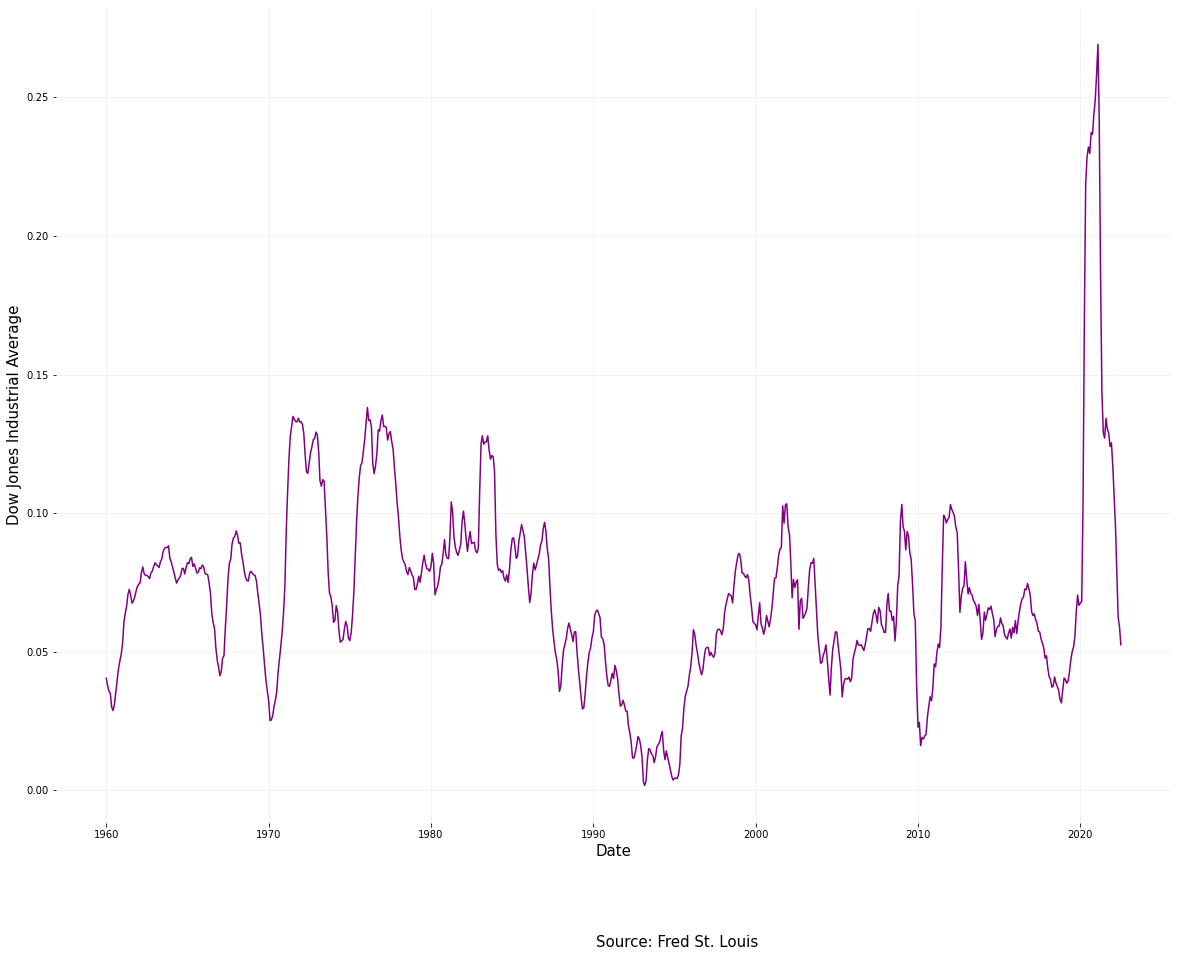

In [12]:
plot_line_graph(
    series_list=m2_growth_list,
    y_label="Dow Jones Industrial Average",
    x_label="Date",
    source='Source: Fred St. Louis'
)

### Plotando o Gráfico: Nível de Preços e Oferta

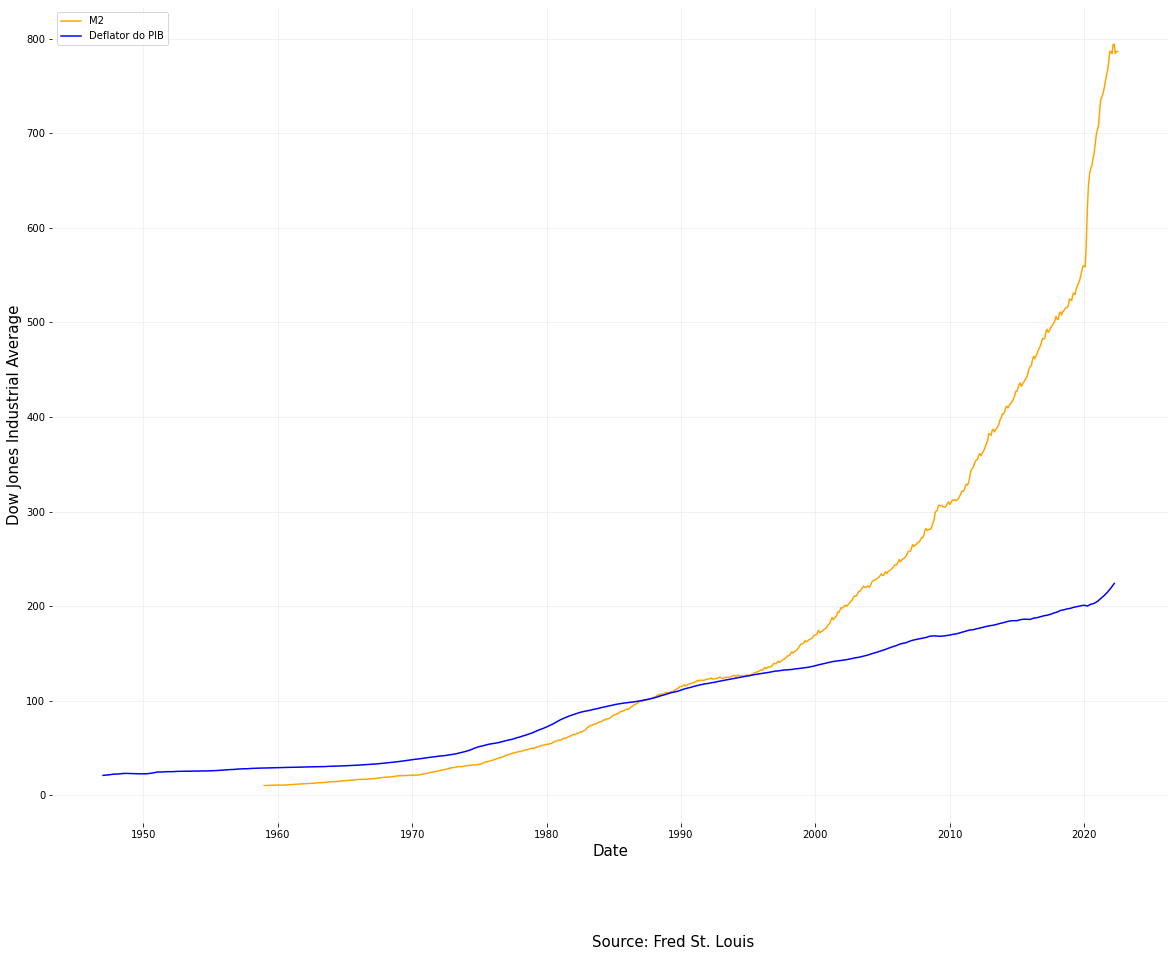

In [13]:
plot_line_graph(
    series_list=def_offer_list,
    y_label="Dow Jones Industrial Average",
    x_label="Date",
    source='Source: Fred St. Louis'
)

## Média de Inflação x Crescimento de Moeda por País

In [14]:

countries = ["Sweden", "United States", "New Zealand", "Denmark",
            "Switzerland", "Japan", "Australia", "Hungary",
            "South Africa", "Malaysia",  "Indonesia",
            "Jordan", "Poland", "Singapore", "Uruguay", "Brazil",
            "Mexico", "Estonia", "Lithuania", "Saudi Arabia",
            "Costa Rica", "Argentina", "Colombia", "Finland", "Bolivia", "Chile",
            "Mozambique", "Tanzania, United Republic of", "Zambia",
            "Turkey", "Ukraine", "Azerbaijan", "Monaco", "Luxembourg"]

alpha_2_sg_list = list()

# Criando uma lista dos paises em formato de sigla alpha_2
for country in countries:
    pycontry_obj = pycountry.countries.get(name = country)
    try:
        alpha_2_sg_list.append(pycontry_obj.alpha_2)
    except Exception as e:
        print("Dados para o pais não encontrados", country , ' | ',e)

country_str = ''
for alpha in alpha_2_sg_list:
    country_str = country_str + alpha + '+'

Dados para o pais não encontrados Bolivia  |  'NoneType' object has no attribute 'alpha_2'


### Conectando com a API do IMF e puxando os dados

In [15]:
# Construindo a url para efetuar a request
base_url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
serie_inflacao = '.PCPI_PC_CP_A_PT.?startPeriod=2000&endPeriod=2022'
serie_moeda =  '.35L___PC_CP_A_PT.?startPeriod=2000&endPeriod=2022'
key_infl = 'CompactData/IFS/A.' + country_str + serie_inflacao
key_m2 = 'CompactData/IFS/A.' + country_str + serie_moeda


def get_imf_data(base_url: str, key: str, series: str):
    # Efetuando a request
    imf_data = (requests.get(f'{base_url}{key}').json()['CompactData']['DataSet']['Series'])


    base_year = imf_data[0]['Obs'][0]['@TIME_PERIOD']
    country = imf_data[0]['@REF_AREA']

    if series=='inflation':
        dataframe_list =  [[int(obs.get('@TIME_PERIOD')), float(obs.get('@OBS_VALUE'))]
        for obs in imf_data[0]['Obs']]
    elif series=='m2':
        dataframe_list = [[int(obs.get('@TIME_PERIOD')), float(obs.get('@OBS_VALUE'))]
        for obs in imf_data[0]['Obs']]

    # Estabelecendo Dataframe base
    dataframe = pd.DataFrame(dataframe_list, columns=['year', country])

    for i in range(1, len(imf_data)):
        try:
            country = imf_data[i]['@REF_AREA']
            if series=='inflation':
                dataframe_list =  [[
                int(obs.get('@TIME_PERIOD')), float(obs.get('@OBS_VALUE'))]
                for obs in imf_data[i]['Obs']]
            elif series=='m2':
                dataframe_list = [[int(obs.get('@TIME_PERIOD')), 
                float(obs.get('@OBS_VALUE'))]
                for obs in imf_data[i]['Obs'] if imf_data[i]['@REF_AREA'] != 'FI']
        except KeyError as e:
            print(type(e), f" | Dados não encontrados para {country}")

        temp_df = pd.DataFrame(dataframe_list, columns=['year', country])
        dataframe = dataframe.merge(temp_df, how='left')

    dataframe.reset_index(inplace=True, drop=True)
    dataframe.set_index(dataframe['year'], inplace=True)
    dataframe.drop(columns=["year"], inplace=True)
    return dataframe

In [16]:
df_inflation = get_imf_data(base_url=base_url, key=key_infl, series='inflation')
df_m2 = get_imf_data(base_url=base_url, key=key_m2, series='m2')

<class 'KeyError'>  | Dados não encontrados para FI


In [17]:
m2_average = pd.DataFrame(df_m2.mean(), columns= ['m2_mean'])
inflation_average = pd.DataFrame(df_inflation.mean(), columns= ['infl_mean'])

# Dataset final para plotagem
m2_infl_df = inflation_average.join(m2_average)

m2_infl_dict = {
    'series': m2_infl_df,
    'x_axis': 'm2_mean',
    'y_axis': 'infl_mean'
}

### Plotando o Gráfico: Media de Inflacao X Crescimento da Moeda

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


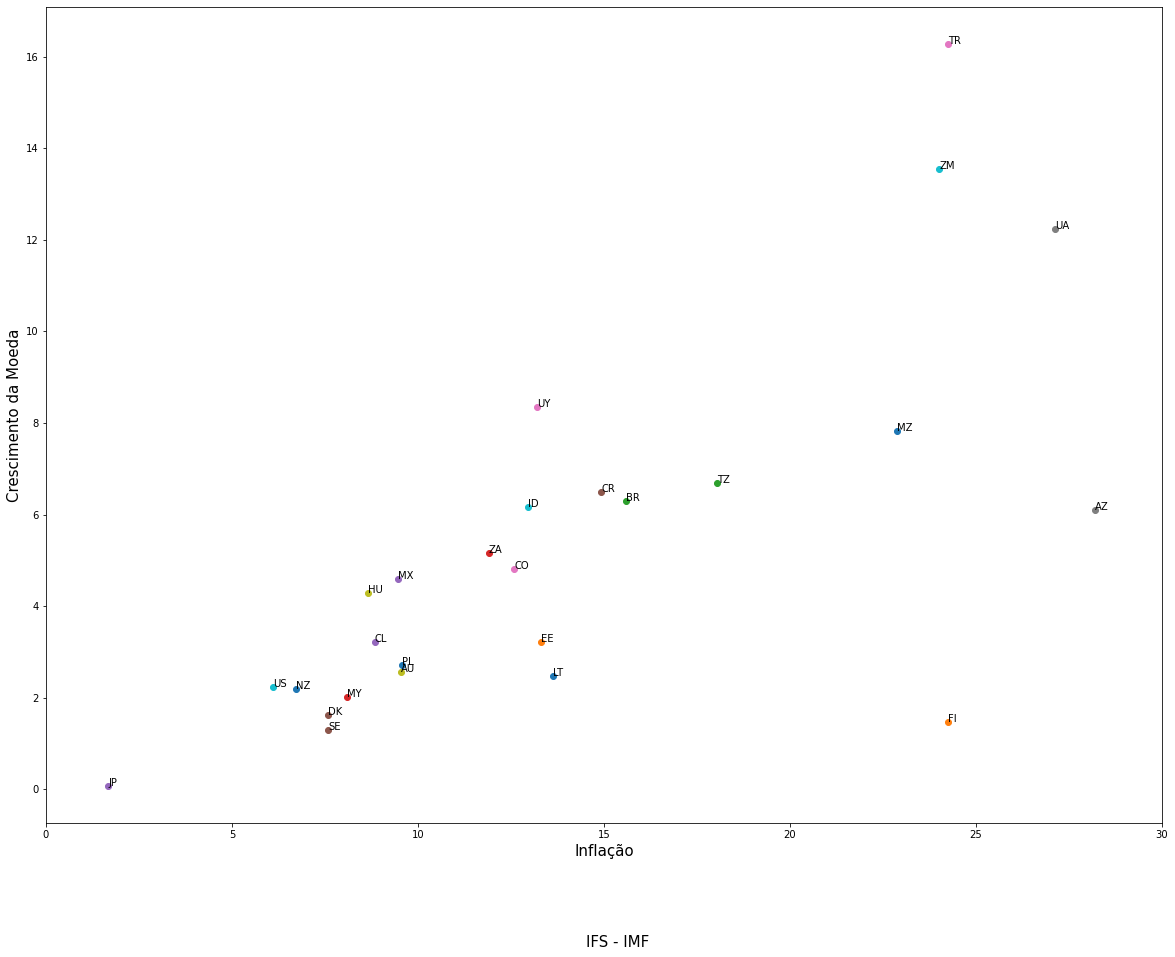

In [18]:
plot_scatter_graph(
    scatter_dict= m2_infl_dict,
    y_label= 'Crescimento da Moeda',
    x_label= 'Inflação',
    source= 'IFS - IMF'
    )

### Plotando o Gráfico: Moeda X Taxa de Juros

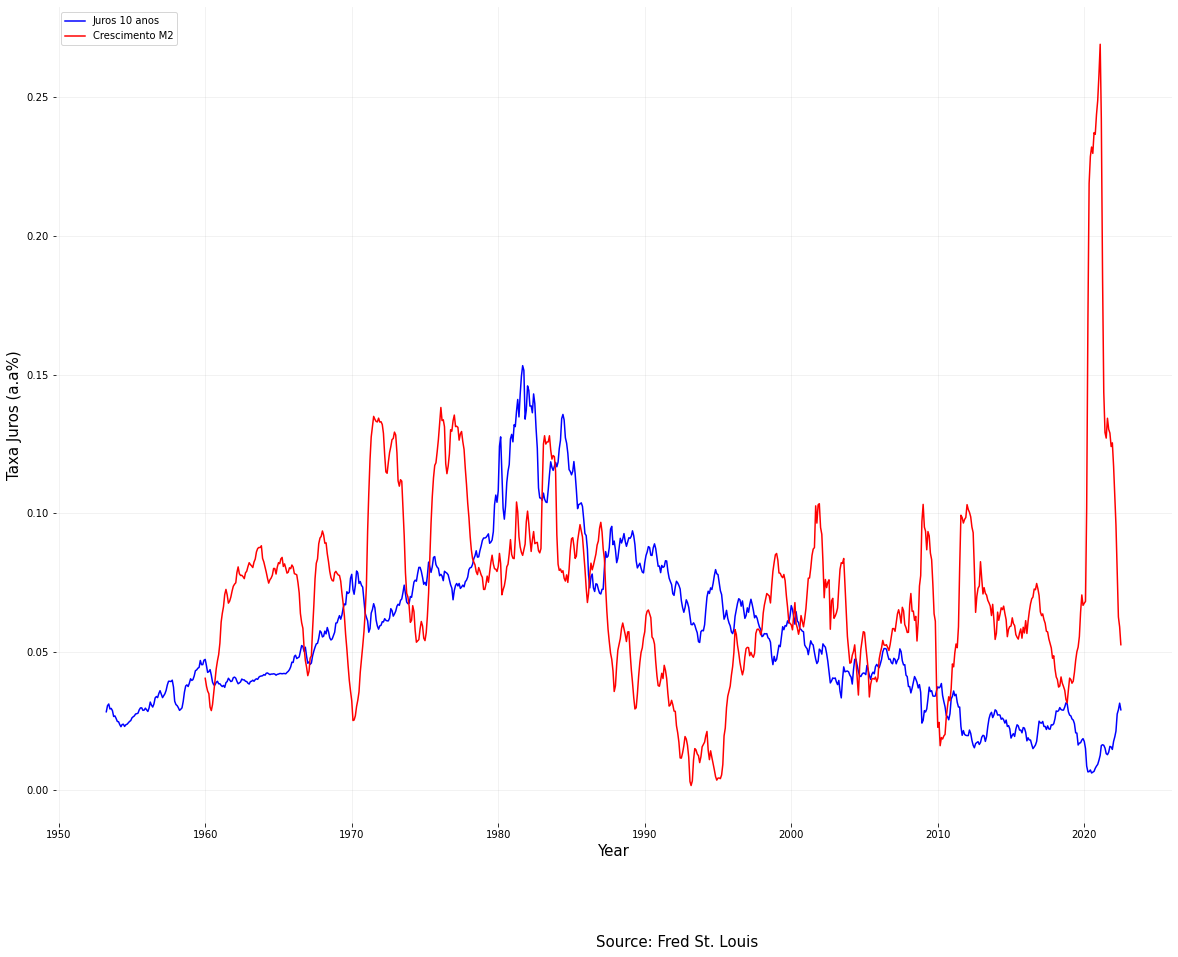

In [19]:
plot_line_graph(
    series_list=offer_int_list,
    y_label= "Taxa Juros (a.a%)",
    x_label='Year',
    source='Source: Fred St. Louis'
)

### Plotando o Gráfico: Déficits Orçamentários

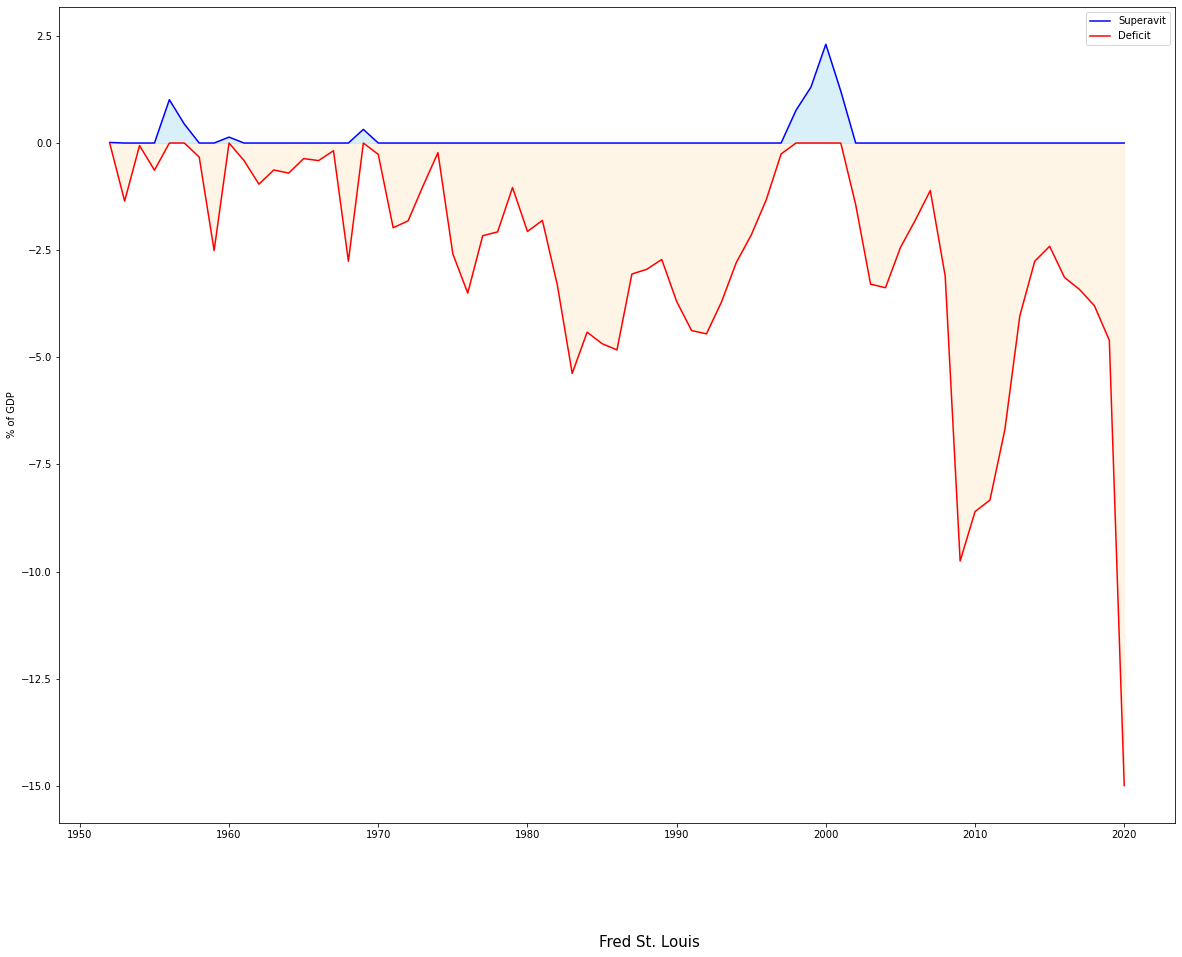

In [24]:
plot_fill_graph(
    dataframe=gdp_def_df,
    series='share',
    label_positive='Superavit',
    label_negative='Deficit',
    y_label='% of GDP',
    x_label='Year',
    source='Fred St. Louis'
)